# Import Libraries

In [85]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [86]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [87]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [208]:
import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import col, when


# Import data before preprocessing

In [210]:
df = spark.read.csv('/content/NYPD_Arrest_Data__Year_to_Date_.csv',header=True,inferSchema=True)

In [211]:
df.show()

+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|     PERP_RACE|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|New Georeferenced Column|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+------------------------+
| 239553009| 01/23/2022|  464|            JOSTLING|  230|            JOSTLING|PL 1652501|         M|          Q|            110|                1|    25-44|       M|         BLACK|   1027679|    214505|     40.7

In [212]:
# get the unique values of the 'LAW_CAT_CD' column
unique_values = df.select('LAW_CAT_CD').distinct().rdd.map(lambda row: row[0]).collect()

print(unique_values)

['F', None, 'M', 'V', '9', 'I']


In [213]:
# filter the dataframe by the condition 'LAW_CAT_CD == "9"'
filtered_df = df.filter(col('LAW_CAT_CD') == '9')

filtered_df.show(5)

+----------+-----------+-----+-------+-----+---------+----------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+----------------+-----------------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|New Georeferenced Column|
+----------+-----------+-----+-------+-----+---------+----------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+----------------+-----------------+------------------------+
| 240613352| 02/15/2022| null| (null)| null|   (null)|CPL5700600|         9|          Q|            113|                3|    25-44|       F|    BLACK|   1046315|    187088|40.6799807384666|-73.7762339071953|    POINT (-73.776233...|
| 239211507| 01/16/2022| null| (null)| null|   (null)|CPL5700600

In [214]:
# Replace null values in the 'LAW_CAT_CD' column with 'N'
df = df.withColumn('LAW_CAT_CD', when(col('LAW_CAT_CD').isNull(),'N').otherwise(col('LAW_CAT_CD')))

# Filter out rows with the value of '9' in the 'LAW_CAT_CD' column
df = df.filter(col('LAW_CAT_CD') != '9')

df.show(5)


+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|   Latitude|   Longitude|New Georeferenced Column|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+------------------------+
| 239553009| 01/23/2022|  464|            JOSTLING|  230|            JOSTLING|PL 1652501|         M|          Q|            110|                1|    25-44|       M|    BLACK|   1027679|    214505|40.75533648|-73.84324519|    POINT (-73.843245...|
| 239922

In [215]:
# count the number of missing values in each column
missing_counts = df.select([spark_sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])

missing_counts.show(5)

+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|New Georeferenced Column|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|         0|          0|  105|      0|  114|        0|       0|         0|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|                       0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+------

In [216]:
# Let us change the the null values in LAW_CAT_CD into N for null
# Our predicitive model will classify them

df = df.withColumn('LAW_CAT_CD', when(col('LAW_CAT_CD').isNull(),'N').otherwise(col('LAW_CAT_CD')))
df.show(5)

+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|   Latitude|   Longitude|New Georeferenced Column|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+------------------------+
| 239553009| 01/23/2022|  464|            JOSTLING|  230|            JOSTLING|PL 1652501|         M|          Q|            110|                1|    25-44|       M|    BLACK|   1027679|    214505|40.75533648|-73.84324519|    POINT (-73.843245...|
| 239922

In [217]:
# count the number of missing values in each column
missing_counts = df.select([spark_sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])

missing_counts.show(5)

+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|New Georeferenced Column|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|         0|          0|  105|      0|  114|        0|       0|         0|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|                       0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+------

In [219]:
# drop any row that contains null values
df = df.na.drop()

df.show(5)


+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|   Latitude|   Longitude|New Georeferenced Column|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+------------------------+
| 239553009| 01/23/2022|  464|            JOSTLING|  230|            JOSTLING|PL 1652501|         M|          Q|            110|                1|    25-44|       M|    BLACK|   1027679|    214505|40.75533648|-73.84324519|    POINT (-73.843245...|
| 239922

## Dividing into 4 Datasets to Create a Relational Database

In [220]:
# get the number of rows and columns in the dataframe
num_rows = df.count()
num_cols = len(df.columns)

print(f"The dataframe has {num_rows} rows and {num_cols} columns.")

The dataframe has 189204 rows and 19 columns.


## Detailed Offense Table

In [221]:
# Create a new dataframe with unique PD_CD and PD_DESC values
pd_df = df.select('PD_CD', 'PD_DESC').dropDuplicates()

## Law Table

In [223]:
# Create a new dataframe with unique LAW_CODE and LAW_CAT_CD values
law_df = df.select('LAW_CODE', 'LAW_CAT_CD').dropDuplicates()

## Offense Table

In [227]:
# Create a new dataframe with unique KY_CD and OFNS_DESC values
ofns_df = df.select('KY_CD', 'OFNS_DESC').dropDuplicates()

## Arrest Table

In [225]:
# drop PD_DESC', 'OFNS_DESC', 'LAW_CAT_CD', 'New Georeferenced Column' columns from the dataframe
arrest_df = df.drop('PD_DESC', 'OFNS_DESC', 'LAW_CAT_CD', 'New Georeferenced Column')

# Data Preprocessing

### Offense Table

In [229]:
# display the schema of the offense table
ofns_df.printSchema()

root
 |-- KY_CD: integer (nullable = true)
 |-- OFNS_DESC: string (nullable = true)



In [230]:
# count the number of null values in each column
null_counts = ofns_df.agg(*[sum(col(c).isNull().cast('int')).alias(c) for c in ofns_df.columns])

# display the result
null_counts.show()

+-----+---------+
|KY_CD|OFNS_DESC|
+-----+---------+
|    0|        0|
+-----+---------+



In [231]:
# convert KY_CD to integer
ofns_df = ofns_df.withColumn('KY_CD', col('KY_CD').cast('int'))

In [232]:
# remove rows where "OFNS_DESC" is (null) or empty
ofns_df = ofns_df.filter(col('OFNS_DESC').isNotNull() & (col('OFNS_DESC') != ''))
ofns_df = ofns_df.filter(col('OFNS_DESC') != '(null)')

In [233]:
# get the shape of the dataframe
num_rows = ofns_df.count()
num_cols = len(ofns_df.columns)

# display the result
print((num_rows, num_cols))

(77, 2)


In [234]:
# While importing the dataframe to sql server, we got an error
# We noticed that two pimary keeys are the same when primary keys should be unique
# filter the dataframe based on KY_CD value
filtered_df = ofns_df.filter(ofns_df['KY_CD'] == 102)

# display the filtered results
filtered_df.show()

+-----+--------------------+
|KY_CD|           OFNS_DESC|
+-----+--------------------+
|  102|HOMICIDE-NEGLIGEN...|
+-----+--------------------+



In [235]:
# drop duplicate rows based on KY_CD column
ofns_df = ofns_df.dropDuplicates(['KY_CD'])

# display the resulting dataframe
ofns_df.show()

+-----+--------------------+
|KY_CD|           OFNS_DESC|
+-----+--------------------+
|  101|MURDER & NON-NEGL...|
|  115|PROSTITUTION & RE...|
|  126|MISCELLANEOUS PEN...|
|  103|HOMICIDE-NEGLIGEN...|
|  236|   DANGEROUS WEAPONS|
|  350|            GAMBLING|
|  578|       HARRASSMENT 2|
|  685|ADMINISTRATIVE CODES|
|  995|FOR OTHER AUTHORI...|
|  122|            GAMBLING|
|  230|            JOSTLING|
|  232|POSSESSION OF STO...|
|  233|          SEX CRIMES|
|  346|ALCOHOLIC BEVERAG...|
|  111|POSSESSION OF STO...|
|  353|UNAUTHORIZED USE ...|
|  355|OFFENSES AGAINST ...|
|  882|    PARKING OFFENSES|
|  363|OFFENSES AGAINST ...|
|  348|VEHICLE AND TRAFF...|
+-----+--------------------+
only showing top 20 rows



In [236]:
filtered_df = ofns_df.filter(ofns_df['KY_CD'] == 102)

# display the filtered results
filtered_df.show()

+-----+--------------------+
|KY_CD|           OFNS_DESC|
+-----+--------------------+
|  102|HOMICIDE-NEGLIGEN...|
+-----+--------------------+



### Detailed Offense Table

In [237]:
# display the schema of the detailed offense table
pd_df.printSchema()

root
 |-- PD_CD: integer (nullable = true)
 |-- PD_DESC: string (nullable = true)



In [238]:
# count the number of null values in each column
null_counts = pd_df.agg(*[sum(col(c).isNull().cast('int')).alias(c) for c in pd_df.columns])

# display the result
null_counts.show()

+-----+-------+
|PD_CD|PD_DESC|
+-----+-------+
|    0|      0|
+-----+-------+



In [239]:
# remove rows where "PD_CD" is (null) or empty
pd_df = pd_df.filter(col('PD_CD').isNotNull() & (col('PD_CD') != ''))
pd_df = pd_df.filter(col('PD_CD') != '(null)')

In [240]:
# display the schema of the detailed offense table
pd_df.printSchema()

root
 |-- PD_CD: integer (nullable = true)
 |-- PD_DESC: string (nullable = true)



### Law Table

In [241]:
# display the schema of the law table
law_df.printSchema()

root
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)



In [242]:
# count the number of null values in each column
null_counts = law_df.agg(*[sum(col(c).isNull().cast('int')).alias(c) for c in law_df.columns])

# display the result
null_counts.show()

+--------+----------+
|LAW_CODE|LAW_CAT_CD|
+--------+----------+
|       0|         0|
+--------+----------+



### Arrest Table

In [244]:
arrest_df.show(5)

+----------+-----------+-----+-----+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+
|ARREST_KEY|ARREST_DATE|PD_CD|KY_CD|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|   Latitude|   Longitude|
+----------+-----------+-----+-----+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+
| 239553009| 01/23/2022|  464|  230|PL 1652501|          Q|            110|                1|    25-44|       M|    BLACK|   1027679|    214505|40.75533648|-73.84324519|
| 239922214| 01/31/2022|  397|  105|PL 1601502|          K|             69|                0|    25-44|       M|    BLACK|   1010576|    175628|  40.648698|  -73.905128|
| 239939130| 02/01/2022|  105|  106|PL 1211200|          K|             61|                0|      65+|       M|    WHITE|    995118|    155708|  40.5

In [245]:
# display the schema of the arrest
arrest_df.printSchema()

root
 |-- ARREST_KEY: integer (nullable = true)
 |-- ARREST_DATE: string (nullable = true)
 |-- PD_CD: integer (nullable = true)
 |-- KY_CD: integer (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: integer (nullable = true)
 |-- JURISDICTION_CODE: integer (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: integer (nullable = true)
 |-- Y_COORD_CD: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [246]:
# count the number of null values in each column
null_counts = arrest_df.agg(*[sum(col(c).isNull().cast('int')).alias(c) for c in arrest_df.columns])

# display the result
null_counts.show()

+----------+-----------+-----+-----+--------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+
|ARREST_KEY|ARREST_DATE|PD_CD|KY_CD|LAW_CODE|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|
+----------+-----------+-----+-----+--------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+
|         0|          0|    0|    0|       0|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|
+----------+-----------+-----+-----+--------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+



In [247]:
# convert 'PD_CD' and 'KY_CD' columns to integer
arrest_df = arrest_df.withColumn('PD_CD', col('PD_CD').cast('integer'))
arrest_df = arrest_df.withColumn('KY_CD', col('KY_CD').cast('integer'))

# convert 'ARREST_DATE' column to datetime
arrest_df = arrest_df.withColumn('ARREST_DATE', to_date(col('ARREST_DATE'),  'yyyy-MM-dd'))

In [248]:
# display the schema of the arrest
arrest_df.printSchema()

root
 |-- ARREST_KEY: integer (nullable = true)
 |-- ARREST_DATE: date (nullable = true)
 |-- PD_CD: integer (nullable = true)
 |-- KY_CD: integer (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: integer (nullable = true)
 |-- JURISDICTION_CODE: integer (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: integer (nullable = true)
 |-- Y_COORD_CD: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



### PK/FK Compatibility

#### Arrest Table

In [250]:
arrest_df.show(5)

+----------+-----------+-----+-----+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+
|ARREST_KEY|ARREST_DATE|PD_CD|KY_CD|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|   Latitude|   Longitude|
+----------+-----------+-----+-----+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+
| 239553009|       null|  464|  230|PL 1652501|          Q|            110|                1|    25-44|       M|    BLACK|   1027679|    214505|40.75533648|-73.84324519|
| 239922214|       null|  397|  105|PL 1601502|          K|             69|                0|    25-44|       M|    BLACK|   1010576|    175628|  40.648698|  -73.905128|
| 239939130|       null|  105|  106|PL 1211200|          K|             61|                0|      65+|       M|    WHITE|    995118|    155708|  40.5

#### First FK: PD_CD

In [252]:
arrest_fk1 = arrest_df.select(col("PD_CD")).distinct().rdd.flatMap(lambda x: x).collect()
print(arrest_fk1)


[808, 580, 879, 799, 970, 918, 513, 876, 593, 155, 744, 530, 193, 101, 115, 772, 847, 939, 874, 183, 596, 762, 784, 688, 501, 577, 916, 844, 271, 973, 223, 548, 409, 578, 663, 707, 285, 209, 685, 727, 493, 122, 625, 157, 725, 476, 519, 177, 711, 827, 665, 696, 185, 694, 906, 291, 748, 581, 259, 512, 297, 674, 792, 440, 760, 16, 168, 205, 178, 972, 164, 500, 139, 479, 283, 582, 339, 944, 969, 507, 544, 268, 191, 258, 729, 397, 419, 553, 644, 117, 579, 764, 904, 15, 511, 269, 112, 849, 563, 775, 843, 862, 179, 659, 523, 461, 502, 197, 531, 462, 263, 107, 9, 586, 505, 175, 746, 695, 498, 503, 594, 35, 610, 583, 739, 742, 698, 441, 733, 766, 537, 173, 114, 494, 301, 687, 922, 719, 49, 380, 176, 520, 877, 514, 637, 244, 627, 664, 649, 565, 439, 273, 585, 277, 794, 438, 532, 706, 166, 129, 661, 779, 907, 509, 848, 589, 750, 293, 817, 267, 793, 759, 812, 261, 181, 510, 576, 289, 889, 113, 645, 125, 697, 968, 477, 29, 464, 798, 256, 195, 490, 595, 809, 203, 782, 640, 662, 265, 724, 899, 801, 5

In [254]:
# PD_CD is the PK in the detailed offense table pd_df
pd_pk = pd_df.select(col("PD_CD")).distinct().rdd.flatMap(lambda x: x).collect()
print(pd_pk)

[]


In [255]:
# convert arrest_fk1 and pd_pk to a set for faster lookup
arrest_fk1 = set(arrest_fk1)
pd_pk_set = set(pd_pk)

# Checking the compatibility (if any FK is missing from the PK set)
error_array = [i for i in arrest_fk1 if i not in pd_pk_set]

# print the missing FKs
print(error_array)

[512, 513, 514, 515, 519, 520, 9, 522, 523, 521, 15, 16, 529, 530, 531, 532, 537, 29, 544, 35, 548, 553, 557, 49, 563, 565, 574, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 589, 593, 594, 595, 596, 610, 101, 104, 105, 106, 107, 109, 112, 625, 114, 115, 627, 117, 113, 122, 637, 125, 639, 640, 129, 638, 643, 644, 645, 649, 139, 652, 659, 661, 662, 663, 664, 665, 153, 155, 157, 674, 164, 166, 168, 681, 170, 685, 173, 175, 688, 177, 178, 179, 687, 176, 694, 183, 696, 185, 695, 698, 181, 697, 186, 191, 701, 193, 706, 707, 195, 197, 708, 711, 198, 199, 201, 203, 204, 205, 718, 719, 209, 724, 725, 727, 729, 733, 223, 739, 742, 744, 746, 748, 750, 244, 759, 760, 248, 762, 764, 766, 254, 256, 258, 259, 772, 261, 775, 263, 265, 779, 268, 269, 267, 271, 784, 273, 782, 781, 785, 277, 788, 792, 793, 794, 283, 285, 798, 799, 289, 801, 291, 803, 293, 802, 808, 297, 809, 812, 301, 817, 827, 841, 843, 844, 847, 848, 849, 339, 862, 872, 874, 876, 877, 174, 879, 878, 889, 379, 380, 899, 904, 9

PK/FK is compatible for PD_CD

### Second FK: KY_CD

In [256]:
# KY_CD is the second FK in the arrest table
arrest_fk2 = arrest_df.select(col("KY_CD")).distinct().rdd.flatMap(lambda x: x).collect()
print(arrest_fk2)

[126, 101, 115, 236, 103, 350, 578, 995, 685, 230, 122, 233, 232, 346, 111, 353, 355, 882, 363, 348, 572, 359, 340, 881, 250, 676, 120, 235, 117, 347, 455, 112, 358, 675, 107, 231, 880, 677, 114, 238, 343, 234, 361, 102, 364, 356, 113, 237, 121, 125, 351, 352, 678, 345, 341, 109, 354, 105, 110, 106, 116, 344, 349, 119, 365, 118, 124, 571, 104]


In [260]:
# KY_CD is the PK in the  offense table ofns_df
ofns_pk = ofns_df.select(col("KY_CD")).distinct().rdd.flatMap(lambda x: x).collect()
print(ofns_pk)

[115, 126, 101, 103, 236, 350, 578, 685, 995, 230, 122, 232, 233, 346, 111, 882, 355, 353, 363, 348, 572, 359, 881, 340, 250, 676, 120, 235, 117, 347, 455, 112, 358, 675, 107, 231, 880, 677, 114, 238, 343, 234, 361, 102, 364, 356, 113, 237, 121, 125, 351, 352, 678, 345, 341, 109, 354, 105, 110, 106, 116, 349, 344, 119, 365, 118, 124, 571, 104]


In [261]:
# convert arrest_fk2 and ofns_pk to a set for faster lookup
arrest_fk2 = set(arrest_fk2)
ofns_pk_set = set(ofns_pk)

# Checking the compatibility (if any FK is missing from thofns_pke PK set)
error_array = [i for i in arrest_fk2 if i not in ofns_pk]

# print the missing FKs
print(error_array)

[]


- PK/FK is compatible for KY_CD

#### Third FK: LAW_CODE

In [263]:
# LAW_CODE is the third FK in the arrest table
arrest_fk3 = arrest_df.select(col("LAW_CODE")).distinct().rdd.flatMap(lambda x: x).collect()
print(arrest_fk3)

['VTL06002AE', 'VTL051101A', 'VTL0402001', 'PL 140100G', 'PL 2206000', 'PL 2101500', 'PL 2204102', 'PL 140200X', 'PL 1309000', 'VTL0511AI0', 'PL 121120X', 'ABC0108000', 'PL 1701501', 'PL 1305002', 'PL 230341A', 'PL 1200301', 'PL 1200505', 'PL 1651504', 'PL 2253003', 'VTL038301B', 'ABC00000V0', 'VTL05110E3', 'PL 1201403', 'PL 2204500', 'PL 2650801', 'PL 1251301', 'AM 0353A00', 'PL 2504505', 'PL 1303503', 'PL 2504504', 'PL 12004D4', 'VTL119201C', 'PL 2403102', 'PL 21551B4', 'PL 21551B1', 'PL 145052H', 'VTL0401B00', 'VTL0511AMU', 'PL 120250H', 'PL 2500500', 'PL 2200605', 'PL 1706503', 'VTL040101A', 'PL 12527WT', 'PL 2402006', 'PL 1553008', 'VTL1192AI1', 'PL 1701001', 'PL 12005WT', 'VTL03750MU', 'PL 2200914', 'COR0168EB3', 'PHL3380005', 'PL 155351H', 'PL 1306504', 'PL 1306503', 'VTL05110FE', 'PL 1051500', 'PL 16515M9', 'VTL03750XA', 'PL 120052X', 'RP 00000MA', 'PL 120058H', 'PL 1201300', 'PL 140251C', 'PL 2403103', 'PL 2653600', 'PL 2203907', 'PL 2302502', 'AC 019190B', 'PL 1201800', 'PL 2

In [265]:
# LAW_CODE is the PK in the  law table law_df
law_pk = law_df.select(col("LAW_CODE")).distinct().rdd.flatMap(lambda x: x).collect()
print(law_pk)

['PL 2206000', 'PL 2101500', 'VTL051101A', 'VTL06002AE', 'VTL0402001', 'PL 140100G', 'ABC0108000', 'PL 2204102', 'PL 121120X', 'VTL0511AI0', 'PL 140200X', 'PL 1309000', 'ABC00000V0', 'VTL038301B', 'PL 1305002', 'PL 1651504', 'PL 1200301', 'PL 2253003', 'PL 1200505', 'PL 1701501', 'PL 230341A', 'PL 2650801', 'PL 1201403', 'VTL05110E3', 'PL 1251301', 'PL 2204500', 'AM 0353A00', 'PL 2504504', 'PL 2504505', 'PL 2403102', 'VTL119201C', 'PL 12004D4', 'PL 1303503', 'PL 21551B1', 'PL 145052H', 'PL 21551B4', 'VTL0401B00', 'PL 2500500', 'VTL0511AMU', 'PL 120250H', 'VTL040101A', 'PL 1706503', 'PL 2200605', 'PL 12527WT', 'PL 2402006', 'PL 12005WT', 'PL 1701001', 'PL 155351H', 'COR0168EB3', 'PHL3380005', 'VTL03750MU', 'PL 1553008', 'VTL1192AI1', 'PL 2200914', 'VTL05110FE', 'PL 1051500', 'PL 120058H', 'PL 16515M9', 'PL 1306503', 'PL 120052X', 'PL 1306504', 'VTL03750XA', 'RP 00000MA', 'PL 2653600', 'PL 2203907', 'PL 140251C', 'PL 2302502', 'PL 2403103', 'PL 1201300', 'PL 130301T', 'PL 1201800', 'PL 1

In [266]:
# convert arrest_fk3 and law_pk to a set for faster lookup
arrest_fk3 = set(arrest_fk3)
law_pk_set = set(law_pk)

# Checking the compatibility (if any FK is missing from thofns_pke PK set)
error_array = [i for i in arrest_fk3 if i not in law_pk]

# print the missing FKs
print(error_array)

[]


- PK/FK is compatible for KY_CD

## Exporting the Updated Dataframes to CSV

In [267]:
pd_df.write.csv('Detailed Offense Table.csv', header=True, mode='overwrite')
ofns_df.write.csv('Offense Table.csv', header=True, mode='overwrite')
law_df.write.csv('Law Table.csv', header=True, mode='overwrite')
arrest_df.write.csv('Arrest Table.csv', header=True, mode='overwrite')

# Exploring the Dataset

### Loading the Dataset

In [143]:
#@title Load arrest data from csv to a dataframe

arrest = spark.read.csv('/content/Arrest Table (1).csv',header=True,inferSchema=True)
arrest.show(5)

+----------+-----------+-----+-----+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+
|ARREST_KEY|ARREST_DATE|PD_CD|KY_CD|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|   Latitude|   Longitude|
+----------+-----------+-----+-----+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+
| 239553009| 2022-01-23|  464|  230|PL 1652501|          Q|            110|                1|    25-44|       M|    BLACK|   1027679|    214505|40.75533648|-73.84324519|
| 239922214| 2022-01-31|  397|  105|PL 1601502|          K|             69|                0|    25-44|       M|    BLACK|   1010576|    175628|  40.648698|  -73.905128|
| 239939130| 2022-02-01|  105|  106|PL 1211200|          K|             61|                0|      65+|       M|    WHITE|    995118|    155708|  40.5

In [144]:
#@title Load law data from csv to a dataframe
law = spark.read.csv('/content/Law Table (1).csv',header=True,inferSchema=True)
law.show(5)
law.printSchema()

+----------+----------+
|  LAW_CODE|LAW_CAT_CD|
+----------+----------+
|PL 1652501|         M|
|PL 1601502|         F|
|PL 1211200|         F|
|PL 1200001|         M|
|PL 1600500|         F|
+----------+----------+
only showing top 5 rows

root
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)



In [145]:
#@title Load detailed offense data from csv to a dataframe
detailed_offense = spark.read.csv('/content/Detailed Offense Table (1).csv',header=True,inferSchema=True)
detailed_offense.show(5)
detailed_offense.printSchema()

+-----+--------------------+
|PD_CD|             PD_DESC|
+-----+--------------------+
|  464|            JOSTLING|
|  397|ROBBERY,OPEN AREA...|
|  105|   STRANGULATION 1ST|
|  101|           ASSAULT 3|
|  705|  FORGERY,ETC.-MISD.|
+-----+--------------------+
only showing top 5 rows

root
 |-- PD_CD: integer (nullable = true)
 |-- PD_DESC: string (nullable = true)



In [146]:
#@title Load offense data from csv to a dataframe
offense = spark.read.csv('/content/Offense Table (1).csv',header=True,inferSchema=True)
offense.show(5)
offense.printSchema()

+-----+--------------------+
|KY_CD|           OFNS_DESC|
+-----+--------------------+
|  230|            JOSTLING|
|  105|             ROBBERY|
|  106|      FELONY ASSAULT|
|  344|ASSAULT 3 & RELAT...|
|  358|OFFENSES INVOLVIN...|
+-----+--------------------+
only showing top 5 rows

root
 |-- KY_CD: integer (nullable = true)
 |-- OFNS_DESC: string (nullable = true)



### Merging the datasets into one

In [147]:
#join all datasets based on a common column in 1 dataframe
arrest2 = arrest.join(law, "LAW_CODE", "leftouter")
arrest2 = arrest2.join(detailed_offense, "PD_CD", "leftouter")
arrest2 = arrest2.join(offense, "KY_CD", "leftouter")

In [148]:
arrest2.show(5)

+-----+-----+----------+----------+-----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+----------+--------------------+--------------------+
|KY_CD|PD_CD|  LAW_CODE|ARREST_KEY|ARREST_DATE|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|   Latitude|   Longitude|LAW_CAT_CD|             PD_DESC|           OFNS_DESC|
+-----+-----+----------+----------+-----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+-----------+------------+----------+--------------------+--------------------+
|  230|  464|PL 1652501| 239553009| 2022-01-23|          Q|            110|                1|    25-44|       M|    BLACK|   1027679|    214505|40.75533648|-73.84324519|         M|            JOSTLING|            JOSTLING|
|  105|  397|PL 1601502| 239922214| 2022-01-31|          K|             69|                0|    25-44|     

In [149]:
from pyspark.sql.functions import when, count, col
#check if we have null in the dataframe
null_counts = arrest2.select([count(when(col(c).isNull(), c)).alias(c) for c in arrest2.columns])
null_counts.show()

+-----+-----+--------+----------+-----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+----------+-------+---------+
|KY_CD|PD_CD|LAW_CODE|ARREST_KEY|ARREST_DATE|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|LAW_CAT_CD|PD_DESC|OFNS_DESC|
+-----+-----+--------+----------+-----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+----------+-------+---------+
|    0|    0|       0|         0|          0|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|         0|      0|        0|
+-----+-----+--------+----------+-----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+----------+-------+---------+



# Spark SQL

In [150]:
# Register Temporary Tables
arrest.createOrReplaceTempView("arrest_table")
law.createOrReplaceTempView("law_table")
offense.createOrReplaceTempView("offense_table")
detailed_offense.createOrReplaceTempView("detailed_offense_table")

## 1.Show the number of arrests made by NYPD 

In [151]:
##-- NYPD arrests are coded as 0, 1 and 2 in JURISDICTION_CODE
spark.sql("SELECT COUNT(*) AS Number_of_arrests_by_NYPD FROM arrest_table WHERE JURISDICTION_CODE < 3").show()

+-------------------------+
|Number_of_arrests_by_NYPD|
+-------------------------+
|                   185149|
+-------------------------+



## 2.Count the number of arrests per race

In [152]:
spark.sql("SELECT PERP_RACE, COUNT(ARREST_KEY) AS Number_per_race FROM arrest_table GROUP BY PERP_RACE ORDER BY Number_per_race DESC").show()

+--------------------+---------------+
|           PERP_RACE|Number_per_race|
+--------------------+---------------+
|               BLACK|          93851|
|      WHITE HISPANIC|          47241|
|               WHITE|          19325|
|      BLACK HISPANIC|          17367|
|ASIAN / PACIFIC I...|          10215|
|             UNKNOWN|            687|
|AMERICAN INDIAN/A...|            518|
+--------------------+---------------+



>**Black** people are the most arrested(93,851) in 2022 in new york.

## 3.Show the number of arrests per Jurisdiction

In [153]:
#0(Patrol), 1(Transit) and 2(Housing) represent NYPD while 3 and more represent non NYPD jurisdictions
spark.sql("SELECT JURISDICTION_CODE, COUNT(ARREST_KEY) AS Number_per_JURISDICTION FROM arrest_table GROUP BY JURISDICTION_CODE ORDER BY Number_per_JURISDICTION DESC").show()

+-----------------+-----------------------+
|JURISDICTION_CODE|Number_per_JURISDICTION|
+-----------------+-----------------------+
|                0|                 171972|
|                1|                   6704|
|                2|                   6473|
|                3|                   1219|
|               97|                    671|
|               15|                    497|
|               72|                    487|
|               73|                    318|
|               11|                    293|
|               71|                    144|
|                4|                    114|
|               14|                    106|
|                7|                    106|
|               87|                     45|
|               88|                     14|
|               69|                     12|
|               13|                      6|
|               16|                      5|
|               85|                      4|
|                9|             

>**Patrol (code 0)** jurisdiction which is represented by nypd has the **highest** number of arrests (171,972).

## 4.Count the number of arrests per age group

In [154]:
spark.sql("SELECT AGE_GROUP, COUNT(ARREST_KEY) AS Number_per_age_group FROM arrest_table GROUP BY AGE_GROUP ORDER BY Number_per_age_group DESC").show()

+---------+--------------------+
|AGE_GROUP|Number_per_age_group|
+---------+--------------------+
|    25-44|              108968|
|    45-64|               37463|
|    18-24|               33111|
|      <18|                6792|
|      65+|                2870|
+---------+--------------------+



>the **age** group between **25-44** has the highest number of arrests(108,968).

## 5.Count the number of arrests per gender

In [155]:
spark.sql("SELECT PERP_SEX, COUNT(ARREST_KEY) AS Number_per_sex FROM arrest_table GROUP BY PERP_SEX ORDER BY Number_per_sex DESC").show()

+--------+--------------+
|PERP_SEX|Number_per_sex|
+--------+--------------+
|       M|        156112|
|       F|         33092|
+--------+--------------+



>**Male** sex has higher number of arrest(156,112) than female.

## 6.Show the number of precincts per Borough 

In [156]:
spark.sql("SELECT  ARREST_BORO, COUNT(DISTINCT ARREST_PRECINCT) AS Number_of_precincts_per_borough FROM arrest_table GROUP BY ARREST_BORO").show()

+-----------+-------------------------------+
|ARREST_BORO|Number_of_precincts_per_borough|
+-----------+-------------------------------+
|          K|                             23|
|          Q|                             16|
|          B|                             12|
|          M|                             23|
|          S|                              4|
+-----------+-------------------------------+



>**Brooklyn** 'K' has the highest number of **precinct**(23) compared to the other boroughs in new york.

## 7.Show the most visited precinct in Brooklyn 'K'

In [157]:
spark.sql("SELECT ARREST_PRECINCT, COUNT(ARREST_KEY) AS Number_of_arrests_per_precinct FROM arrest_table WHERE ARREST_BORO = 'K' GROUP BY ARREST_BORO, ARREST_PRECINCT ORDER BY Number_of_arrests_per_precinct DESC").show()

+---------------+------------------------------+
|ARREST_PRECINCT|Number_of_arrests_per_precinct|
+---------------+------------------------------+
|             75|                          5706|
|             73|                          3850|
|             67|                          3099|
|             84|                          2887|
|             79|                          2815|
|             60|                          2544|
|             70|                          2432|
|             72|                          2425|
|             83|                          2311|
|             77|                          2271|
|             90|                          2245|
|             71|                          2067|
|             63|                          1870|
|             69|                          1769|
|             62|                          1716|
|             81|                          1682|
|             68|                          1540|
|             61|   

## 8.Show the borough or town that has the highest number of arrests

In [158]:
spark.sql("SELECT ARREST_BORO, COUNT(*) as num_arrests FROM arrest_table GROUP BY ARREST_BORO ORDER BY num_arrests DESC LIMIT 1").show()

+-----------+-----------+
|ARREST_BORO|num_arrests|
+-----------+-----------+
|          K|      50930|
+-----------+-----------+



## 9.Show the offense that is occuring most

In [159]:
spark.sql("SELECT offense_table.OFNS_DESC, COUNT(arrest_table.ARREST_KEY) AS Number_per_offense FROM arrest_table  JOIN offense_table ON arrest_table.KY_CD = offense_table.KY_CD GROUP BY offense_table.OFNS_DESC ORDER BY Number_per_offense DESC").show()

+--------------------+------------------+
|           OFNS_DESC|Number_per_offense|
+--------------------+------------------+
|ASSAULT 3 & RELAT...|             30687|
|       PETIT LARCENY|             20637|
|      FELONY ASSAULT|             18895|
|MISCELLANEOUS PEN...|             12523|
|     DANGEROUS DRUGS|             10651|
|CRIMINAL MISCHIEF...|             10174|
|             ROBBERY|              9943|
|       GRAND LARCENY|              9019|
|   DANGEROUS WEAPONS|              8018|
|VEHICLE AND TRAFF...|              7206|
|            BURGLARY|              6253|
|OFFENSES AGAINST ...|              5533|
|OFFENSES INVOLVIN...|              4837|
|          SEX CRIMES|              4283|
|OFF. AGNST PUB OR...|              3838|
|             FORGERY|              3635|
|   THEFT OF SERVICES|              2773|
|POSSESSION OF STO...|              2620|
|INTOXICATED & IMP...|              2432|
|FOR OTHER AUTHORI...|              1747|
+--------------------+------------

>**ASSAULT 3 & RELATED OFFENSES** is the most type of arrest in new york.



## 10.Show the most occuring offense in brooklyn 'K' 

In [160]:
spark.sql("SELECT offense_table.OFNS_DESC, COUNT(arrest_table.ARREST_KEY) AS Number_per_offense_in_K FROM arrest_table JOIN offense_table ON arrest_table.KY_CD = offense_table.KY_CD WHERE arrest_table.ARREST_BORO = 'K' GROUP BY offense_table.OFNS_DESC, arrest_table.ARREST_BORO ORDER BY Number_per_offense_in_K DESC").show()


+--------------------+-----------------------+
|           OFNS_DESC|Number_per_offense_in_K|
+--------------------+-----------------------+
|ASSAULT 3 & RELAT...|                   8035|
|      FELONY ASSAULT|                   5357|
|       PETIT LARCENY|                   4542|
|MISCELLANEOUS PEN...|                   4343|
|CRIMINAL MISCHIEF...|                   2955|
|   DANGEROUS WEAPONS|                   2744|
|             ROBBERY|                   2685|
|     DANGEROUS DRUGS|                   2253|
|       GRAND LARCENY|                   2163|
|VEHICLE AND TRAFF...|                   2058|
|            BURGLARY|                   1775|
|   THEFT OF SERVICES|                   1231|
|OFF. AGNST PUB OR...|                   1137|
|             FORGERY|                   1018|
|OFFENSES INVOLVIN...|                   1013|
|OFFENSES AGAINST ...|                   1012|
|          SEX CRIMES|                    988|
|POSSESSION OF STO...|                    720|
|INTOXICATED 

>**ASSAULT 3 & RELATED OFFENSES** is the most type of arrest in brooklyn 'K'.

## 11.Show the detailed offense that is occuring most 

In [161]:
spark.sql("SELECT detailed_offense_table.PD_DESC, COUNT(arrest_table.ARREST_KEY) AS Number_per_detailed_offense FROM arrest_table JOIN detailed_offense_table ON arrest_table.PD_CD = detailed_offense_table.PD_CD GROUP BY detailed_offense_table.PD_DESC ORDER BY Number_per_detailed_offense DESC").show()

+--------------------+---------------------------+
|             PD_DESC|Number_per_detailed_offense|
+--------------------+---------------------------+
|           ASSAULT 3|                      22218|
|LARCENY,PETIT FRO...|                      20558|
|ASSAULT 2,1,UNCLA...|                      13929|
|ROBBERY,OPEN AREA...|                       9896|
|PUBLIC ADMINISTRA...|                       8590|
|LARCENY,GRAND FRO...|                       7785|
|TRAFFIC,UNCLASSIF...|                       6832|
|BURGLARY,UNCLASSI...|                       5578|
|MENACING,UNCLASSI...|                       5400|
|CONTROLLED SUBSTA...|                       5244|
|  FORGERY,ETC.-MISD.|                       4833|
|CRIMINAL POSSESSI...|                       4679|
|  CRIMINAL MIS 2 & 3|                       4079|
|CRIMINAL MISCHIEF...|                       3652|
|FORGERY,ETC.,UNCL...|                       3560|
|   STRANGULATION 1ST|                       3483|
|AGGRAVATED HARASS...|         

>**Assualt 3** is the most detailed offense occuring in new york.

## 12.Show the detailed offense in the top 1 offense that is occuring most

In [162]:
spark.sql("SELECT offense_table.OFNS_DESC, detailed_offense_table.PD_DESC, COUNT(arrest_table.ARREST_KEY) AS Number_per_offense FROM arrest_table JOIN offense_table ON arrest_table.KY_CD = offense_table.KY_CD JOIN detailed_offense_table ON arrest_table.PD_CD = detailed_offense_table.PD_CD WHERE offense_table.OFNS_DESC = 'ASSAULT 3 & RELATED OFFENSES' GROUP BY detailed_offense_table.PD_DESC, offense_table.OFNS_DESC ORDER BY Number_per_offense DESC").show()

+--------------------+--------------------+------------------+
|           OFNS_DESC|             PD_DESC|Number_per_offense|
+--------------------+--------------------+------------------+
|ASSAULT 3 & RELAT...|           ASSAULT 3|             22218|
|ASSAULT 3 & RELAT...|MENACING,UNCLASSI...|              5400|
|ASSAULT 3 & RELAT...| OBSTR BREATH/CIRCUL|              3069|
+--------------------+--------------------+------------------+



>**Assualt 3** has **22,218** number of arrest in 2022.

## 13.Count the number of arrests per unique location using longitude and latitude in each Borough

In [163]:
spark.sql("SELECT Latitude, Longitude, ARREST_BORO, COUNT(ARREST_KEY) AS Number_per_location FROM arrest_table GROUP BY Latitude, Longitude, ARREST_BORO ORDER BY Number_per_location DESC").show()

+---------+----------+-----------+-------------------+
| Latitude| Longitude|ARREST_BORO|Number_per_location|
+---------+----------+-----------+-------------------+
|40.671404|-73.881509|          K|               1441|
|40.810391|-73.924895|          B|               1347|
|40.887325|-73.847247|          B|               1291|
|40.644996|-74.077263|          S|               1046|
|40.853578|-73.900591|          B|               1026|
|40.726284| -73.73476|          Q|               1017|
|40.769552|-73.915361|          Q|                933|
|40.707439|-73.792139|          Q|                905|
|40.648859| -73.95082|          K|                897|
|40.750423| -73.98928|          M|                885|
|40.837774|-73.919455|          B|                884|
|40.762037|-73.827328|          Q|                875|
|40.671104|-73.913562|          K|                861|
|40.823378|-73.870168|          B|                853|
|40.720528|-74.007582|          M|                850|
|40.737074

The most dangerous locations found in each of the boroughs in our dataset are:
- Manhattan: Harlem, Midtown, Chelsea, East Village, Lower East Side
- Bronx: Mott Haven, Port Morris, Hunts Point
- Queens: Corona, Jackson Heights, Elmhurst
- Brooklyn: Bedford-Stuyvesant, Crown Heights, East New York, Brownsville

## 14.Show the number of arrests occuring in the most dangerous neighborhood in NY which is Hunts Point (latitude 40.8094 and longitude -73.8803)

In [164]:
spark.sql("SELECT Latitude, Longitude, COUNT(ARREST_KEY) AS Number_per_location FROM arrest_table WHERE Latitude BETWEEN 40.80 AND 40.81 AND Longitude BETWEEN -73.89 AND -73.88 GROUP BY Latitude, Longitude ORDER BY Number_per_location DESC").show()


+-----------+------------+-------------------+
|   Latitude|   Longitude|Number_per_location|
+-----------+------------+-------------------+
|40.80724695|-73.88170196|                  4|
|  40.808189|  -73.881949|                  3|
|  40.808646|  -73.885427|                  2|
|  40.806901|  -73.884017|                  2|
|  40.807319|  -73.881252|                  2|
|40.80655169|-73.88631601|                  1|
|40.80682982|-73.88447329|                  1|
|40.80536082|-73.88121044|                  1|
|  40.807464|  -73.880299|                  1|
|  40.805613|  -73.886068|                  1|
|  40.806345|  -73.887707|                  1|
|40.80467381|-73.88582074|                  1|
+-----------+------------+-------------------+



## 15.Find the number of arrests per month

In [165]:
spark.sql("SELECT MONTH(ARREST_DATE) AS Arrest_Month, COUNT(*) AS Arrest_Count FROM arrest_table GROUP BY MONTH(ARREST_DATE) ORDER BY Arrest_Count DESC").show()

+------------+------------+
|Arrest_Month|Arrest_Count|
+------------+------------+
|          10|       17087|
|           3|       16901|
|          11|       16607|
|           5|       16505|
|           6|       16374|
|           4|       16040|
|           9|       15836|
|           7|       15745|
|           8|       15683|
|          12|       15254|
|           2|       14024|
|           1|       13148|
+------------+------------+



>**October,2022** has the highest number of arrests which is 17,087.

## 16.Find the number of arrests per month in Brooklyn K 

In [166]:
spark.sql("SELECT MONTH(ARREST_DATE) AS Arrest_Month, COUNT(*) AS Arrest_Count FROM arrest_table WHERE ARREST_BORO = 'K' GROUP BY ARREST_BORO, MONTH(ARREST_DATE) ORDER BY Arrest_Count DESC").show()

+------------+------------+
|Arrest_Month|Arrest_Count|
+------------+------------+
|           3|        4687|
|           5|        4570|
|           6|        4438|
|           4|        4417|
|          10|        4412|
|          11|        4323|
|           8|        4267|
|           7|        4215|
|           9|        4146|
|          12|        4145|
|           2|        3717|
|           1|        3593|
+------------+------------+



>**March,2022** has the highest number of arrests in Brooklyn 'K'.

## 17.Find the number of arrests per level of offense (LAW_CAT_CD) 

In [167]:
## LAW_CAT_CD (Felony F, Violation V,  Misdemeanor M, Infraction I or Unknown N)
spark.sql("SELECT LAW_CAT_CD, COUNT(ARREST_KEY) AS Arrest_Count FROM arrest_table JOIN law_table ON arrest_table.LAW_CODE = law_table.LAW_CODE GROUP BY LAW_CAT_CD ORDER BY Arrest_Count DESC").show()

+----------+------------+
|LAW_CAT_CD|Arrest_Count|
+----------+------------+
|         M|      101435|
|         F|       84988|
|         N|        1747|
|         V|         797|
|         I|         237|
+----------+------------+



>**Misdemeanor** 'M' is the **most level of offense** used in new york where **101,435** arrest where sent to it in 2022.

> 

# EDA

### Total Arrests By Borough

In [168]:
# Group the arrests by country and count the number of arrests
country_counts = arrest.groupBy("ARREST_BORO").count().orderBy("count", ascending=False)
# Extract the top 10 countries with the highest arrest counts
top_countries = country_counts.limit(10).toPandas()
# Create a bar plot using Matplotlib
import plotly.express as px

# Create a bar plot using Plotly Express
fig1 = px.bar(top_countries, x="ARREST_BORO", y="count", title="Arrests by Borough")
fig1.update_xaxes(tickvals=top_countries["ARREST_BORO"], ticktext=['Brooklyn', 'Manhattan', 'Bronx', 'Queens', 'Staten Island'])
fig1.show()

### Total Arrests By Age

In [169]:
# Group the arrests by country and count the number of arrests
age_counts = arrest.groupBy("AGE_GROUP").count().orderBy("count", ascending=False)
# Extract the top 10 countries with the highest arrest counts
top_age = age_counts.limit(10).toPandas()
# Create a bar plot using Matplotlib
import plotly.express as px

# Create a bar plot using Plotly Express
fig = px.bar(top_age, x="AGE_GROUP", y="count", title="Arrests by Age")
fig.show()

### Total Arrests By Race

In [170]:
# Group the arrests by country and count the number of arrests
race_counts = arrest.groupBy("PERP_RACE").count().orderBy("count", ascending=False)
# Extract the top 10 countries with the highest arrest counts
top_race = race_counts.limit(10).toPandas()
# Create a bar plot using Matplotlib
import plotly.express as px

# Create a bar plot using Plotly Express
fig = px.bar(top_race, x="PERP_RACE", y="count", title="Arrests by Race")
fig.show()

### Total Arrests By Gender

In [171]:
# Group the arrests by country and count the number of arrests
sex_counts = arrest.groupBy("PERP_SEX").count().orderBy("count", ascending=False)
# Extract the top 10 countries with the highest arrest counts
top_sex = sex_counts.limit(10).toPandas()
# Create a bar plot using Matplotlib
import plotly.express as px

# Create a bar plot using Plotly Express
fig = px.bar(top_sex, x="PERP_SEX", y="count", title="Arrests by Sex")
fig.show()

### Total Arrests by Age, Race and Gender

<ipython-input-172-cce7efd109ab>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-172-cce7efd109ab>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



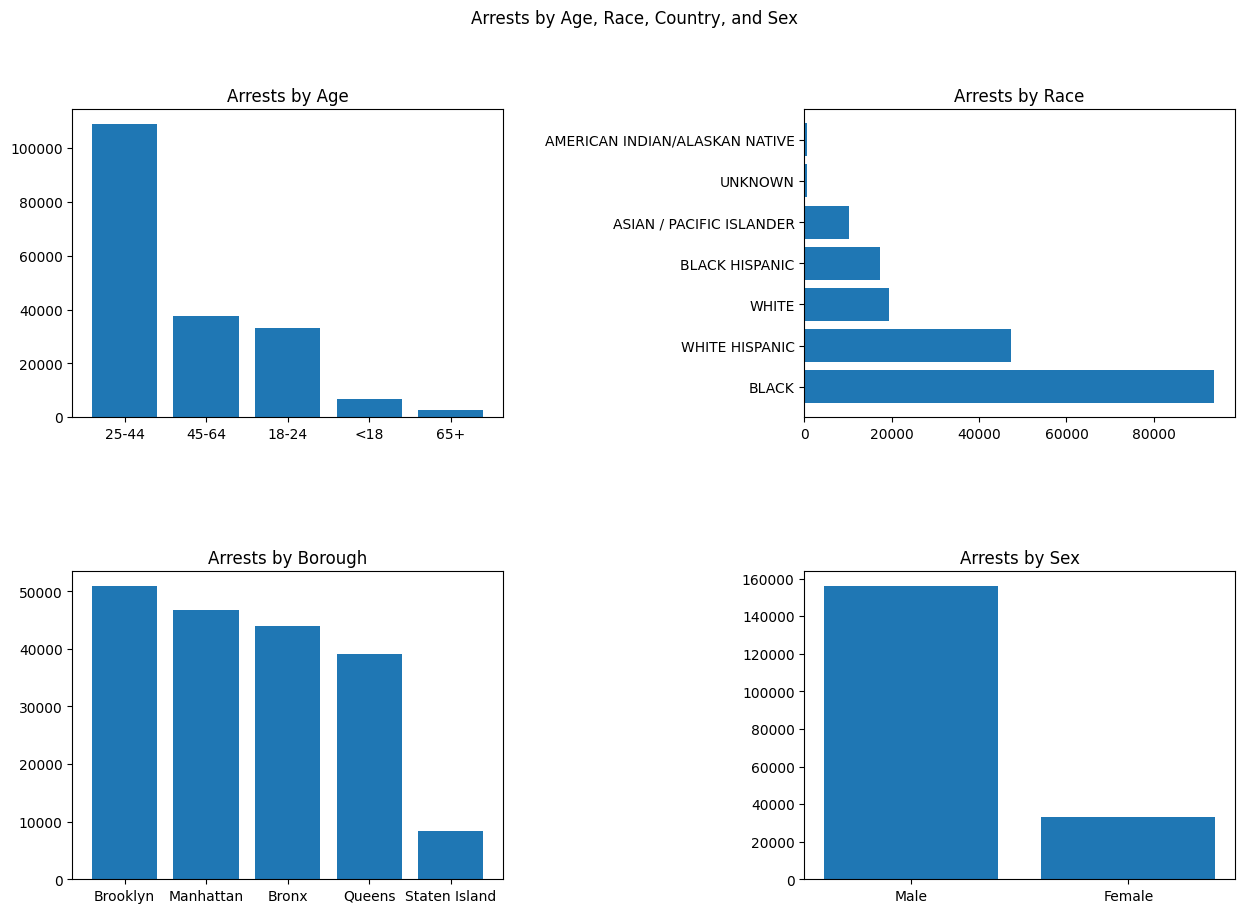

In [172]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Add bar plots to each subplot
axs[0, 0].bar(top_age["AGE_GROUP"], top_age["count"])
axs[0, 0].set_title("Arrests by Age")

axs[0, 1].barh(top_race["PERP_RACE"], top_race["count"])
axs[0, 1].set_title("Arrests by Race")

axs[1, 0].bar(top_countries["ARREST_BORO"], top_countries["count"])
axs[1, 0].set_title("Arrests by Borough")
axs[1, 0].set_xticklabels(["Brooklyn", "Manhattan", "Bronx", "Queens", "Staten Island"])

axs[1, 1].bar(top_sex["PERP_SEX"], top_sex["count"])
axs[1, 1].set_title("Arrests by Sex")
axs[1, 1].set_xticklabels(["Male", "Female"])

# Adjust spacing and add a title
fig.subplots_adjust(wspace=0.7, hspace=0.5)

fig.suptitle("Arrests by Age, Race, Country, and Sex")

# Show the plot
plt.show()

As we can see:
>The highest arrest count by **age** is between 25 and 44 years old.

>The **borough** were we have the highest arrest count is is Brooklyn.

> **Male** arrests are higher than female arrests.

>**Black** people have the highest arrest count.

### Total Arrests Per Precinct

In [173]:
from pyspark.sql.functions import col

In [174]:
# Group the arrests by precinct and count the number of arrests
precinct_counts = arrest.groupBy("ARREST_PRECINCT").count().orderBy(col("count").desc())
# Convert the result to a Pandas DataFrame for plotting
precinct_counts_df = precinct_counts.toPandas()

fig = px.bar(precinct_counts_df, x="ARREST_PRECINCT", y="count", 
             title="Arrests by Precinct", labels={"ARREST_PRECINCT": "Precinct", "count": "Number of Arrests"})
fig.update_layout(xaxis_tickangle=-90)

fig.show()

- **Precinct 14** has the highest number of arrests.

### Total Arrests Per Precinct in Brooklyn

In [175]:
# Filter the arrests to only include those in Brooklyn
brooklyn_arrests = arrest.filter(col("ARREST_BORO") == "K")

# Group the arrests by precinct and count the number of arrests
precinct_counts = brooklyn_arrests.groupBy("ARREST_PRECINCT").count().orderBy(col("count").desc())

# Create a bar plot using Plotly Express
fig = px.bar(precinct_counts.toPandas(), x="ARREST_PRECINCT", y="count", 
             labels={"ARREST_PRECINCT": "Precinct", "count": "Number of Arrests"}, 
             title="Arrests by Precinct in Brooklyn")
fig.update_layout(xaxis_tickangle=-90)
fig.show()


- In Brooklyn, Precinct 75 has the highest number of arrests

### Level of Offense as a Pie Chart

In [176]:
from pyspark.sql import functions as F

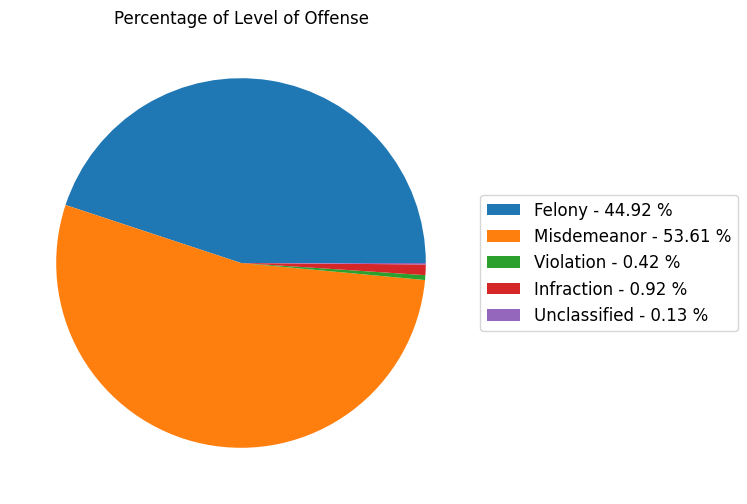

In [177]:
# Calculate the percentage of each LAW_CAT_CD
law_cat_count = arrest2.groupBy("LAW_CAT_CD").count()
total_count = law_cat_count.agg(F.sum("count")).collect()[0][0]
law_cat_percentage = law_cat_count.withColumn(
    "percentage", F.col("count") / total_count * 100
)

# Define a color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

# Get the unique categories in the LAW_CAT_CD column
categories = ['Felony', 'Misdemeanor', 'Violation', 'Infraction', 'Unclassified']

# Convert the percentage data to a Pandas dataframe and plot it in a pie chart
pie_chart = law_cat_percentage.toPandas().plot.pie(
    y="percentage",
    labels=None,
    colors=colors,
    figsize=(6, 6),
)

# Add percentages as labels outside the pie chart
percentages = law_cat_percentage.select("percentage").rdd.flatMap(lambda x: x).collect()
labels = ['{0} - {1:1.2f} %'.format(categories[i], percentages[i]) for i in range(len(categories))]
plt.legend(labels, loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=12)

plt.ylabel("")
plt.title("Percentage of Level of Offense")
plt.show()


>**53.91%** of level of offense are occured in **Misdemeanor**.

### Jurisdiction Group as a Pie Chart

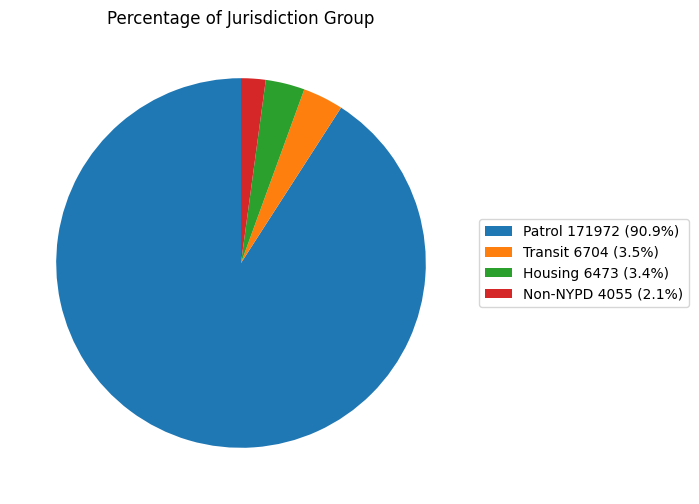

In [178]:
# Create a new column to group the jurisdiction codes
arrest3 = arrest.withColumn(
    "jurisdiction_group",
    when(col("JURISDICTION_CODE") > 2, "Non-NYPD").otherwise(
        when(col("JURISDICTION_CODE") == 0, "Patrol").otherwise(
            when(col("JURISDICTION_CODE") == 1, "Transit").otherwise(
                when(col("JURISDICTION_CODE") == 2, "Housing")
            )
        )
    )
)

# Group by the jurisdiction group and count the number of arrests in each group
jurisdiction_count = (
    arrest3.groupBy("jurisdiction_group").count().orderBy("count", ascending=False)
)

# Define a color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Convert the data to a Pandas dataframe
jurisdiction_count_pd = jurisdiction_count.toPandas()

# Create the pie chart
pie_chart = jurisdiction_count_pd.plot.pie(
    y="count",
    labels=None, # Remove labels from the figure
    colors=colors,
    autopct=None, # Remove percentage from the figure
    startangle=90,
    figsize=(6, 6),
)

plt.ylabel("")
plt.title("Percentage of Jurisdiction Group")

# Add the labels and percentages to the legend
plt.legend(
    labels=jurisdiction_count_pd["jurisdiction_group"] + " " + 
    jurisdiction_count_pd["count"].astype(str) + " (" +
    (jurisdiction_count_pd["count"]/jurisdiction_count_pd["count"].sum()*100).round(1).astype(str) + "%)",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

plt.show() 


>**Patrol** is the most jurisdiction group that have the **highest** number of arrest.

### Number of Arrests Per Offense

In [179]:
import findspark


import os


# Set the SPARK_HOME environment variable
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# Add the PySpark/py4j packages to the Python path
findspark.init()


In [180]:
import plotly.graph_objects as go
import pyspark.sql.functions

# Group the dataset by offense and count the number of arrests per offense
offense_counts = arrest.join(offense, arrest.KY_CD == offense.KY_CD)\
                      .groupBy('OFNS_DESC')\
                      .agg(pyspark.sql.functions.count('*').alias('counts'))\
                      .orderBy('counts', ascending=False)


# Get the top 7 offenses
top_offenses = offense_counts.limit(7)

# Convert to Pandas DataFrame for plotting
offense_counts_df = top_offenses.toPandas()

# Create a bar chart using Plotly Express
fig = go.Figure(go.Bar(
    x=offense_counts_df['counts'],
    y=offense_counts_df['OFNS_DESC'],
    orientation='h'
))

fig.update_layout(title='Number of Arrests Per Offense',
                  xaxis_title='Number of Occurrences')

fig.show()


## Number of Arrests Per Detailed Offense

In [181]:
import plotly.graph_objects as go

# Group the dataset by offense and count the number of arrests per offense
detailed_offense_counts = arrest.join(detailed_offense, arrest.PD_CD == detailed_offense.PD_CD)\
                      .groupBy('PD_DESC')\
                      .agg(count('*').alias('counts'))\
                      .orderBy('counts', ascending=False)

# Get the top 7 offenses
top_detailed_offenses = detailed_offense_counts.limit(7)

# Convert to Pandas DataFrame for plotting
detailed_offense_counts_df = top_detailed_offenses.toPandas()

# Create a bar chart using Plotly Express
fig = go.Figure(go.Bar(
    x=detailed_offense_counts_df['counts'],
    y=detailed_offense_counts_df['PD_DESC'],
    orientation='h'
))

fig.update_layout(title='Number of Arrests Per Detailed Offense',
                  xaxis_title='Number of Occurrences')

fig.show()

## Time-Related Visuals

In [182]:
from pyspark.sql.functions import count, to_date

# Convert ARREST_DATE column to date type
arrest = arrest.withColumn('ARREST_DATE', to_date(arrest.ARREST_DATE, 'yyyy-MM-dd'))

# Group arrests by date and count the number of arrests per date
arrest_count = arrest.groupBy('ARREST_DATE').agg(count('*').alias('arrests'))

# Convert to Pandas DataFrame for plotting
arrest_count_df = arrest_count.toPandas()

# Create a line plot using Plotly Express
fig = px.bar(arrest_count_df, x='ARREST_DATE', y='arrests', title='Number of Arrests by Date')
fig.show()

In [183]:
from pyspark.sql.functions import month

# Create a new column with the month of the arrest
arrest_month = arrest.withColumn("month", month("ARREST_DATE"))

# Group by month and count the number of arrests
arrests_per_month = arrest_month.groupBy("month").count().orderBy("month")

# Convert to Pandas DataFrame for plotting
arrests_per_month_df = arrests_per_month.toPandas()

# Create a bar plot using Plotly Express
fig = px.bar(arrests_per_month_df, x="month", y="count", 
             labels={"month": "Month", "count": "Number of Arrests"},
             title="Number of Arrests per Month in NYC")
fig.show()


We can notice that **October** has the highest number of arrests

# Predictive model

In [187]:
arrest2.columns

['KY_CD',
 'PD_CD',
 'LAW_CODE',
 'ARREST_KEY',
 'ARREST_DATE',
 'ARREST_BORO',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude',
 'LAW_CAT_CD',
 'PD_DESC',
 'OFNS_DESC']

In [188]:
arrest2.dtypes

[('KY_CD', 'int'),
 ('PD_CD', 'int'),
 ('LAW_CODE', 'string'),
 ('ARREST_KEY', 'int'),
 ('ARREST_DATE', 'string'),
 ('ARREST_BORO', 'string'),
 ('ARREST_PRECINCT', 'int'),
 ('JURISDICTION_CODE', 'int'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'string'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'int'),
 ('Y_COORD_CD', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('LAW_CAT_CD', 'string'),
 ('PD_DESC', 'string'),
 ('OFNS_DESC', 'string')]

## Feature engineering

In [189]:
df=arrest2

In [190]:
from pyspark.sql.functions import dayofweek, month, dayofmonth

# Convert the ARREST_DATE column to a datetime type
df = df.withColumn('ARREST_DATE', df['ARREST_DATE'].cast('timestamp'))

#Extract month, day, and day of the week
df = df.withColumn('ARREST_MONTH', month(df['ARREST_DATE']))
df = df.withColumn('ARREST_DAY', dayofmonth(df['ARREST_DATE']))
df = df.withColumn('DAY_OF_WEEK', dayofweek(df['ARREST_DATE']))

# Show the updated DataFrame
df.show()


+-----+-----+----------+----------+-------------------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+----------+--------------------+--------------------+------------+----------+-----------+
|KY_CD|PD_CD|  LAW_CODE|ARREST_KEY|        ARREST_DATE|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|     PERP_RACE|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|LAW_CAT_CD|             PD_DESC|           OFNS_DESC|ARREST_MONTH|ARREST_DAY|DAY_OF_WEEK|
+-----+-----+----------+----------+-------------------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+----------+--------------------+--------------------+------------+----------+-----------+
|  230|  464|PL 1652501| 239553009|2022-01-23 00:00:00|          Q|            110|                1|    25-44|       M|         BLACK|   1027679|    2145

In [191]:
columns_to_drop = ['KY_CD', 'PD_CD', 'LAW_CODE', 'ARREST_KEY', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude','PD_DESC','ARREST_DATE']
df = df.drop(*columns_to_drop)
df.show(5)

+-----------+---------------+-----------------+---------+--------+---------+----------+--------------------+------------+----------+-----------+
|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|LAW_CAT_CD|           OFNS_DESC|ARREST_MONTH|ARREST_DAY|DAY_OF_WEEK|
+-----------+---------------+-----------------+---------+--------+---------+----------+--------------------+------------+----------+-----------+
|          Q|            110|                1|    25-44|       M|    BLACK|         M|            JOSTLING|           1|        23|          1|
|          K|             69|                0|    25-44|       M|    BLACK|         F|             ROBBERY|           1|        31|          2|
|          K|             61|                0|      65+|       M|    WHITE|         F|      FELONY ASSAULT|           2|         1|          3|
|          M|             28|                0|    45-64|       M|    BLACK|         M|ASSAULT 3 & RELAT...|           2|        1

In [192]:
from pyspark.sql.functions import col

# Create a dataframe that includes only the unclassified level of offenses. These observations will be classified after creating our model
test=df.filter(df['LAW_CAT_CD'] == 'N')

# Drop the unclassified from the dataframe in order to train our model
df = df.filter(col("LAW_CAT_CD") != "N")

unique_values = df.select(col('LAW_CAT_CD')).distinct().collect()
print([row['LAW_CAT_CD'] for row in unique_values])

['F', 'M', 'V', 'I']


## Splitting 

In [193]:
numerical_vars=['ARREST_PRECINCT','JURISDICTION_CODE','ARREST_MONTH','ARREST_DAY','DAY_OF_WEEK']
categ_vars=['ARREST_BORO','AGE_GROUP','PERP_SEX','PERP_RACE', 'OFNS_DESC']

## Random Forest Classifier Model

In [194]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler

# Drop the rows where LAW_CAT_CD is "N"
df = df.filter(df.LAW_CAT_CD != "N")

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Define the categorical and numerical columns
categ_vars=['ARREST_BORO', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'OFNS_DESC']
numerical_vars=['ARREST_PRECINCT', 'JURISDICTION_CODE', 'ARREST_MONTH', 'ARREST_DAY', 'DAY_OF_WEEK']

# Define the stages for the pipeline
stages = []

# StringIndexer for the target variable
label_stringIdx = StringIndexer(inputCol="LAW_CAT_CD", outputCol="label")
stages += [label_stringIdx]

# OneHotEncoder for the categorical variables
for categorical_col in categ_vars:
    stringIndexer = StringIndexer(inputCol=categorical_col, outputCol=categorical_col+"_Index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categorical_col+"_classVec"])
    stages += [stringIndexer, encoder]

# Assemble all the features into a single vector column
assemblerInputs = [c+"_classVec" for c in categ_vars] + numerical_vars
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Scale the features to a range [0, 1]
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
stages += [scaler]

# Train a Random Forest model
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=50)
stages += [rf]

# Define the pipeline
pipeline = Pipeline(stages=stages)

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.8941445635691293


In [196]:
# Evaluate the model using weighted precision and recall
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedPrecision")
weighted_precision = evaluator.evaluate(predictions)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="weightedRecall")
weighted_recall = evaluator.evaluate(predictions)

print("Weighted Precision: {:.4f}".format(weighted_precision))
print("Weighted Recall: {:.4f}".format(weighted_recall))


Weighted Precision: 0.9003
Weighted Recall: 0.8941
